In [6]:
!git clone https://github.com/haipradana/indobert-indonesia-sarcastic-satire-classification.git
%cd indobert-indonesia-sarcastic-satire-classification

fatal: destination path 'indobert-indonesia-sarcastic-satire-classification' already exists and is not an empty directory.
/kaggle/working/indobert-indonesia-sarcastic-satire-classification


In [ ]:
!pip install -q transformers datasets accelerate evaluate scikit-learn matplotlib seaborn pandas

In [ ]:
!pip install --upgrade transformers datasets evaluate
# then restart

In [2]:
import torch
from datasets import load_dataset, Features, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration setup

In [3]:
import os

model_name = "indobenchmark/indobert-base-p1"
dataset_path = 'dataset/final_dataset.csv'

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

classes = ['0', '1']
NUM_LABELS = len(classes)

# Load Tokenizer and Model

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_LABELS, ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prepare Dataset for Training

In [7]:
from datasets import Value

features = Features(
    {'text' : Value('string'),
    'label' : ClassLabel(names=classes)}
)
dataset = load_dataset('csv', data_files={'train':dataset_path}, features=features)

def tokenize_func(examples):
    if isinstance(examples["text"], list):
        texts_to_tokenize = [str(text) for text in examples["text"]]
    else:
        texts_to_tokenize = str(examples["text"])
    return tokenizer(texts_to_tokenize, padding='max_length', truncation=True, max_length=512)
    
tokenized_datasets = dataset.map(tokenize_func, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/17100 [00:00<?, ? examples/s]

### Split 70/15/15

In [8]:
from sklearn.model_selection import train_test_split

train_val = tokenized_datasets["train"].train_test_split(test_size=0.15, seed=42)
train_test_split = train_val["train"].train_test_split(test_size=0.15/0.85, seed=42)

train_dataset = train_test_split['train']
test_dataset = train_test_split['test']
val_dataset = train_val['test']

print(f"Total training: {len(train_dataset)}, with ({len(train_dataset)/len(tokenized_datasets['train']):.0%})")
print(f"Total test: {len(test_dataset)}, with ({len(test_dataset)/len(tokenized_datasets['train']):.0%})")
print(f"Total training: {len(val_dataset)}, with ({len(val_dataset)/len(tokenized_datasets['train']):.0%})")

Total training: 11970, with (70%)
Total test: 2565, with (15%)
Total training: 2565, with (15%)


# Configure Evaluation Metrics

In [9]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary", pos_label=1)['precision']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary", pos_label=1)["f1"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary", pos_label=1)["recall"]


    return {"accuracy":accuracy,
           "precision": precision,
           "f1": f1,
           "recal": recall}

In [10]:
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_ratio=0.08,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", 
)

In [11]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
)

# Training

In [12]:
trainer.train()
print("Fine-tuned completed!")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,F1,Recal
1,0.455900,0.351192,0.840936,0.902235,0.826087,0.761792
2,0.249100,0.392364,0.833918,0.783512,0.845876,0.919025
3,0.119800,0.597988,0.842885,0.818782,0.847059,0.877358
4,0.043900,0.949691,0.844444,0.823094,0.847884,0.874214
5,0.009700,0.996249,0.852242,0.842146,0.852930,0.863994


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fine-tuned completed!


# Logs

In [13]:
import pandas as pd 

logs = trainer.state.log_history
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(output_dir, "training_logs.csv"), index=False)
print("Logs saved!")

Logs saved!


# Evaluation Model

In [14]:
predictions_output = trainer.predict(test_dataset)

pred_labels = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [15]:
accuracy = accuracy_metric.compute(predictions=pred_labels, references=true_labels)['accuracy']
precision = precision_metric.compute(predictions=pred_labels, references=true_labels, average="binary", pos_label=1)['precision']
f1 = f1_metric.compute(predictions=pred_labels, references=true_labels, average="binary", pos_label=1)["f1"]
recall = recall_metric.compute(predictions=pred_labels, references=true_labels, average="binary", pos_label=1)["recall"]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8378
Precision: 0.8405
F1-Score: 0.8345
Recall: 0.8286


## confusion matrix

Image saved


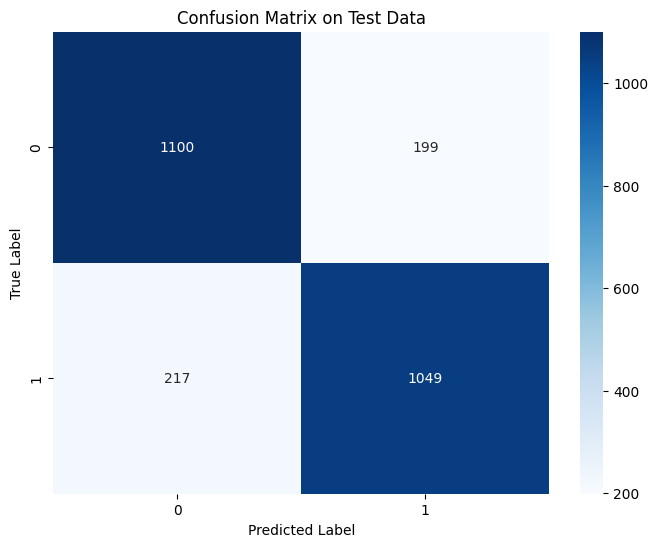

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels,pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path)
print('Image saved')
plt.show()

In [17]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")
print(f"Best metric value: {trainer.state.best_metric}")
print("hehe")

Best model checkpoint path: output/checkpoint-3745
Best metric value: 0.852929763290648
hehe
